# Dropping a ball
# Group Members: Kai Stewart, Felix Yu, Lili Houston, Sadhya Garg
Written by Tim Atherton for Computational Physics
    - Modified by: Kai Stewart, Felix Yu
January 16, 2020

This program aims to simulate the motion of a ball dropped from an initial height of $y0$ under gravity $g$ using the Euler discretization.

## Import libraries for plotting and numerical work

In [97]:
import sys
print(sys.version)

3.8.1 (v3.8.1:1b293b6006, Dec 18 2019, 14:08:53) 
[Clang 6.0 (clang-600.0.57)]


In [98]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
%matplotlib inline

## Set up general parameters for the calculation
- Gravitational acceleration constant: $10 \frac{m}{s^2}$

- Initial height: $y_0$ in $m$
- Initial velocity: $v_0$ in $\frac{m}{s}$
- Initial time: $t_0$ in $s$
- Time resolution: $dt$ in $0.1s$
- Total simulation time: $t_f$ in $s$, which is set later right before running the loop

In [99]:
params = {'g': 10, 'y0': 1.0, 'v0': 0, 't0': 0, 'dt': 0.033, 'tf': 0.0} 

## Set the properties of the ball under investigations
- The properties $S_b$ of the individual balls is a collection of elements pertaining to the various physical properties of the ball in the test set.
- Property list:
    - Ball mass: $m$ in grams
    - Ball radius: $r$ in mm
    - Ball surface area: $s_a = 4\pi r^2$ in mm$^2$ 
    - Drag coefficient: Encapsulates all other complex factors in determining drag penalty, and were estimated from our tracker data. The ideal sphere has drag coefficient 0.47.
    - Final time: the time taken, by experiment, for the ball to hit the ground in $s$
- Red Foam Ball
    - $S_r:$ $\{$ $m:$ 0.40, $r:$ (14.5, 16.5), $s_a:$ 3019.07, $drag:$ 0.5, $tf:$ 0.5667 $\}$
    - Note: The surface area of the red ball is computed using $r = \frac{1}{2}r_1r_2$
- Black Rubber Ball
    - $S_b:$ $\{$ $m:$ 24.55, $r:$ 19.9, $s_a:$ 4976.4, $drag:$ 0.47, $tf:$ 0.435 $\}$
- White Plastic Ball
    - $S_w:$ $\{$ $m:$ 2.80, $r:$ 20.1, $s_a:$ 5076.94, $drag:$ 0.47, $tf:$ 0.4683 $\}$

In [100]:
Sr = {'color': 'Red',   'm': 0.40, 'r': 15.5, 's_a': 3019.07, 'drag': 0.5, 'tf': 0.5667}
Sb = {'color': 'Black', 'm': 24.55, 'r': 19.9, 's_a': 4976.40, 'drag': 0.47, 'tf': 0.435}
Sw = {'color': 'White', 'm': 2.80, 'r': 20.1, 's_a': 5076.94, 'drag': 0.47, 'tf': 0.4683}

### Standard drag penalty equation (drag at high velocity)
#### Function Contract: coefficient of drag, surface area of object, velocity of object, mass of object
- [Documentation](https://www.nuclear-power.net/nuclear-engineering/fluid-dynamics/what-is-drag-air-and-fluid-resistance/drag-force-drag-equation/)
- Units: m = grams, area = mm$^2$, velocity = m/s, coefficient = unitless
- Calculates the drag acceleration of an object with the given properties

In [101]:
def drag_accel(coefficient, area, flow_v, m):
    return (coefficient * (area * 0.000001) * ((1.225 * (flow_v**2))/2)) / (m * 0.001)

### Stoke's drag equation (low Reynold's number)
#### Function Contract: radius of object, velocity of object, mass of object
- [Documentation](https://en.wikipedia.org/wiki/Stokes%27_law)
- Units: m = grams, radius = mm, velocity = m/s
- Calculates the drag acceleration of an object with the given properties

In [102]:
def stokes_drag_accel(r, flow_v, m):
    return (6 * math.pi * 0.0000181 * (r * 0.001) * flow_v) / (m * 0.001)

### Simulation quality determination function
- We propose the use of the Mean-Squared Error (MSE) as a quality metric for our simulation algorithm
- The MSE is used to assess the quality of a predictor function in its ability to estimate the outputs of another function. In this case, the simulation acts as our predictor function and the data provided by the tracker software represent the outputs we wish to map to.

#### Definition:

- $n$ is the number of point predictions in the simulation
- $X$ is a vector of observed values of the variable being predicted
- $\hat{X}$ is a vector of predictions
- The Mean-Squared Error of the prediction is:
    
$\text{MSE} = \frac{1}{n} \sum_{i=1}^n (X - \hat{X})^2 $

##### Function contract:
- predictions: a numpy array of values produced by the ball drop simulation algorithm
- targets: a numpy array of values produced by the tracker software

In [103]:
def MSE(predictions, targets):
    return np.square(np.subtract(predictions, targets)).mean()

### Euler Algorithm

#### Function Contract
- tracker_y (array): array of values loaded from the output of the Tracker software
- S (dict): collection of parameters describing a particular ball in the test set
- params (dict): collection of physical parameters describing the constraints of the experiment

In [104]:
def euler(tracker_y, S, params=params):
    # Set up the time measurements to match exactly with our tracker data
    params['tf'] = S['tf']
    params['nsteps'] = int( params['tf'] / params['dt'] ) + 1
    
    # Setup arrays for performing and tracking computations
    t = np.linspace(params['t0'], params['tf'], params['nsteps'])
    v = np.zeros([params['nsteps']])
    y = np.zeros([params['nsteps']])
    
    # Set the simulation to same start position as tracker data
    y[0] = tracker_y[0] 
    v[0] = params['v0']

    for i in range(1, params['nsteps']):
        v[i] = v[i-1] + (params['dt'] * (-params['g'] + drag_accel(S['drag'], S['r'], v[i-1], S['m'])))
        y[i] = y[i-1] + v[i] * params['dt']
    
    y = y[y != 0.]     # ensure data is all non-zero
    y = y.clip(min=0.) # clip negative values
    y = y[y > 0.]      # truncate array leaving only non-zero values
    t = t[0:len(y)]    # ensure that the arrays are the same length for plotting
    return y, t

### Bashforth-Adams Algorithm

#### Function Contract
- tracker_y (array): array of values loaded from the output of the Tracker software
- S (dict): collection of parameters describing a particular ball in the test set
- params (dict): collection of physical parameters describing the constraints of the experiment

In [105]:
def bash_adams(tracker_y, S, params=params):
    # Set up the time measurements to match exactly with our tracker data
    params['tf'] = S['tf']
    params['nsteps'] = int( params['tf'] / params['dt'] ) + 1
    
    # Setup arrays for performing and tracking computations
    t = np.linspace(params['t0'], params['tf'], params['nsteps'])
    v = np.zeros([params['nsteps']])
    y = np.zeros([params['nsteps']])
    
    # Set the simulation to same start position as tracker data
    y[0] = tracker_y[0]
    # Take one step to initialize the computation
    v[1] = v[0] + (params['dt'] * (-params['g'] + drag_accel(S['drag'], S['r'], v[0], S['m'])))
    y[1] = y[0] + v[0] * params['dt']

    for i in range(2, params['nsteps']):
        v[i] = v[i-1] + (params['dt'] * (-params['g'] + drag_accel(S['drag'], S['r'], v[i-1], S['m'])))
        y[i] = y[i-1] + ( (3/2) * params['dt'] * v[i-1] ) - ( (1/2) * params['dt'] * v[i-2] )

    y = y[y != 0.]     # ensure data is all non-zero
    y = y.clip(min=0.) # clip negative values
    y = y[y > 0.]      # truncate array leaving only non-zero values
    t = t[0:len(y)]    # ensure that the arrays are the same length for plotting
    return y, t

#### Plotting Function

In [106]:
def make_plots(tracker_y, tracker_t, sim_y, sim_t, S, algo=None):
    fig, axes = plt.subplots(1,2, sharey=True)

    plt.suptitle('Simulation Algorithm vs Tracker Data')

    # Plot simulation data
    axes[0].plot(sim_t, sim_y, color='k')
    if algo is not None:
        axes[0].set_title("{} Algorithm".format(algo))
    else:
        axes[0].set_title("Algorithm")
    # Label the axes
    axes[0].set_xlabel('Time [s]')
    axes[0].set_ylabel('Height [m]')

    # Mark the start and end points of the simulated data
    axes[0].scatter(0.0, sim_y[0], label='({}, {})'.format(round(sim_t[0], 2), round(sim_y[0], 2) ), color='g')
    axes[0].scatter(sim_t[-1], sim_y[-1], label='({}, {})'.format(round(sim_t[-1], 2), round(sim_y[-1], 2)), color='r')

    # Plot tracker data
    axes[1].plot(tracker_t, tracker_y, color='b')
    axes[1].set_title('{} Ball'.format(S['color']))
    axes[1].set_xlabel('Time [s]')

    # Mark the start and end points of the Tracker generated data
    label = '({}, {})'.format(round(tracker_t[0], 2), round(tracker_y[0], 2) )
    axes[1].scatter(tracker_t[0], tracker_y[0], label=label, color='g')

    label = '({}, {})'.format(round(tracker_t[-1], 2), round(tracker_y[-1], 2))
    axes[1].scatter(tracker_t[-1], tracker_y[-1], label=label, color='r')

    # Legends
    axes[0].legend()
    axes[1].legend()

    if algo is not None:
        plt.savefig('ball_drop_{}_{}_algo.png'.format(S['color'], algo), dpi=300)
    else:
        plt.savefig('ball_drop_{}_.png'.format(S['color']), dpi=300)

## Computation of simulated trajectories using ball properties
- Note: We choose acceleration due to gravity to have a negative sign and penalize by adding drag in the positive direction

### Simulate Red Ball Trajectory

#### Load Red Ball Data from text file

In [107]:
red_ball = pd.read_csv('red_ball.txt', delimiter="\t")

In [108]:
red_t = red_ball['t']; red_x = red_ball['x']; red_y = red_ball['y']

In [109]:
red_y = red_y.values[0: len(red_y.values)].clip(min=0.) # Convert to np array and clip negative values
red_y = red_y[red_y > 0.] # push non-zero values up

In [110]:
red_t = red_t.values[0:len(red_y)]

#### Compute Trajectory using the Euler Algorithm

In [111]:
y_r_e, t_r_e = euler(red_y, Sr)

#### Compute Trajectory using the Bashforth-Adams Algorithm

In [112]:
y_r_ba, t_r_ba = bash_adams(red_y, Sr)

#### Plot comparison between Euler simulation and Tracker data

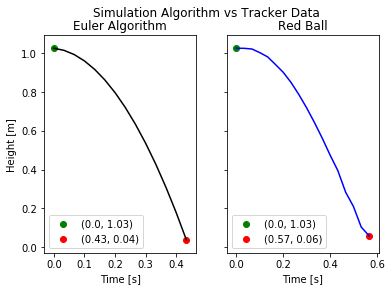

In [113]:
make_plots(red_y, red_t, y_r_e, t_r_e, Sr, algo='Euler')

#### Plot comparison between BA simulation and Tracker data

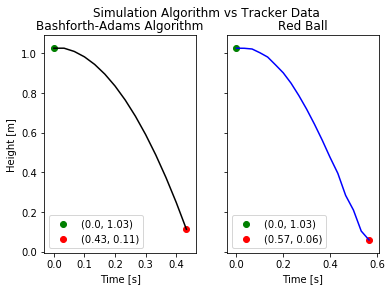

In [114]:
make_plots(red_y, red_t, y_r_ba, t_r_ba, Sr, algo='Bashforth-Adams')

#### Get the MSE for the predictions vs targets

In [115]:
red_euler_MSE = MSE(y_r_e, red_y[0:len(y_r_e)])

In [116]:
print("The Mean-Squared Error for the {} ball using the Euler Algorithm is {}".format(Sr['color'], round(red_euler_MSE, 3)))

The Mean-Squared Error for the Red ball using the Euler Algorithm is 0.03


In [117]:
red_ba_MSE = MSE(y_r_ba, red_y[0:len(y_r_ba)] )

In [118]:
print("The Mean-Squared Error for the {} ball using the Bashforth-Adams Algorithm is {}".format(Sr['color'], round(red_ba_MSE, 3)))

The Mean-Squared Error for the Red ball using the Bashforth-Adams Algorithm is 0.017


### Simulate Black Ball Trajectory

#### Load Black Ball Data from text file

In [119]:
black_ball = pd.read_csv('black_ball.txt', delimiter="\t")

In [120]:
black_t = black_ball['t']; black_x = black_ball['x']; black_y = black_ball['y']

In [121]:
black_y = black_y.values[0: len(black_y.values)].clip(min=0.) # Convert to np array and clip negative values
black_y = black_y[black_y > 0.] # push non-zero values up

In [122]:
black_t = black_t.values[0:len(black_y)]

#### Compute Trajectory using the Euler Algorithm

In [123]:
y_b_e, t_b_e = euler(black_y, Sb)

#### Compute Trajectory using Bashforth-Adams Algorithm

In [124]:
y_b_ba, t_b_ba = bash_adams(black_y, Sb)

#### Plot comparison between Euler simulation and Tracker data

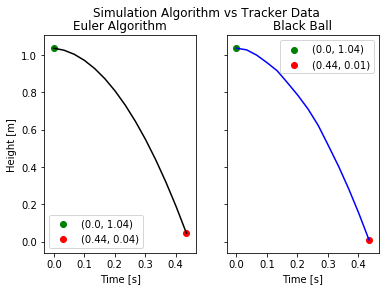

In [125]:
make_plots(black_y, black_t, y_b_e, t_b_e, Sb, algo="Euler")

#### Plot comparison between BA simulation and Tracker data

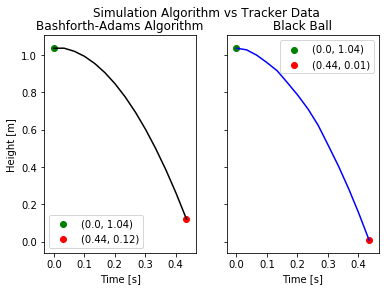

In [126]:
make_plots(black_y, black_t, y_b_ba, t_b_ba, Sb, algo="Bashforth-Adams")

#### Get the MSE for the predictions vs targets

In [127]:
black_euler_MSE = MSE(y_b_e, black_y[0:len(y_b_e)])

In [128]:
print("The Mean-Squared Error for the {} ball using the Euler Algorithm is {}".format(Sb['color'], round(black_euler_MSE, 3)))

The Mean-Squared Error for the Black ball using the Euler Algorithm is 0.001


In [129]:
black_BA_MSE = MSE(y_b_ba, black_y[0:len(y_b_ba)])

In [130]:
print("The Mean-Squared Error for the {} ball using the BA Algorithm is {}".format(Sb['color'], round(black_BA_MSE, 3)))

The Mean-Squared Error for the Black ball using the BA Algorithm is 0.005


## Simulate White Ball Trajectory

#### Load White Ball Data from Text File

In [131]:
white_ball = pd.read_csv('white_ball.txt', delimiter="\t")

In [132]:
white_t = white_ball['t']; white_x = white_ball['x']; white_y = white_ball['y']

In [133]:
white_y = white_y.values[0: len(white_y.values)].clip(min=0.) # Convert to np array and clip negative values
white_y = white_y[white_y > 0.] # push non-zero values up

In [134]:
white_t = white_t.values[0:len(white_y)]

#### Compute Trajectory using the Euler Algorithm

In [135]:
y_w_e, t_w_e = euler(white_y, Sw)

#### Compute Trajectory using Bashforth-Adams Algorithm

In [136]:
y_w_ba, t_w_ba = bash_adams(white_y, Sw)

#### Plot comparison between Euler simulation and Tracker data

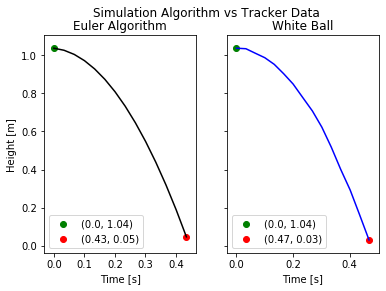

In [137]:
make_plots(white_y, white_t, y_w_e, t_w_e, Sw, algo="Euler")

#### Plot comparison between BA simulation and Tracker data

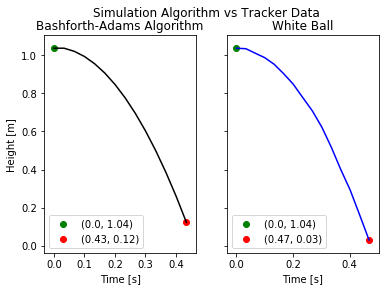

In [138]:
make_plots(white_y, white_t, y_w_ba, t_w_ba, Sw, algo="Bashforth-Adams")

#### Get the MSE for the predictions vs targets

In [139]:
white_euler_MSE = MSE(y_w_e, white_y[0:len(y_w_e)])

In [140]:
print("The Mean-Squared Error for the {} ball using the Euler Algorithm is {}".format(Sw['color'], round(white_euler_MSE, 3)))

The Mean-Squared Error for the White ball using the Euler Algorithm is 0.004


In [141]:
white_BA_MSE = MSE(y_w_ba, white_y[0:len(y_w_ba)])

In [142]:
print("The Mean-Squared Error for the {} ball using the BA Algorithm is {}".format(Sw['color'], round(white_BA_MSE, 3)))

The Mean-Squared Error for the White ball using the BA Algorithm is 0.0


In [143]:
euler_MSE = [red_euler_MSE, black_euler_MSE, white_euler_MSE]
ba_MSE    = [red_ba_MSE, black_BA_MSE, white_BA_MSE]

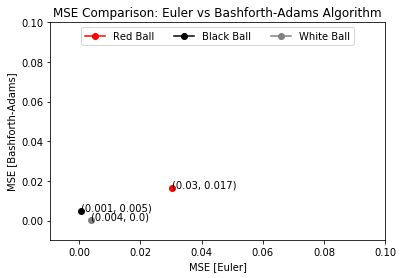

In [144]:
plt.title("MSE Comparison: Euler vs Bashforth-Adams Algorithm")

# Set the plotting limits
plt.xlim((min(euler_MSE) - 0.01, 0.10))
plt.ylim((min(ba_MSE) - 0.01, 0.10))

# Set the axes labels
plt.xlabel('MSE [Euler]')
plt.ylabel('MSE [Bashforth-Adams]')

# MSE scores - red ball
plt.plot(red_euler_MSE, red_ba_MSE, marker='o', color='r', label="Red Ball")
xy = (red_euler_MSE, red_ba_MSE)
l1, l2 = round(red_euler_MSE, 3), round(red_ba_MSE, 3)
plt.annotate( (l1, l2), xy=xy, textcoords='data')

# MSE scores - black ball
plt.plot(black_euler_MSE, black_BA_MSE, marker='o', color='k',    label="Black Ball")
xy = (black_euler_MSE, black_BA_MSE)
l1, l2 = round(black_euler_MSE, 3), round(black_BA_MSE, 3)
plt.annotate( (l1, l2), xy=xy, textcoords='data')

# MSE scored - white ball
plt.plot(white_euler_MSE, white_BA_MSE, marker='o', color='gray', label='White Ball')
xy = (white_euler_MSE, white_BA_MSE)
l1, l2 = round(white_euler_MSE, 3), round(white_BA_MSE, 3)
plt.annotate( (l1, l2), xy=xy, textcoords='data')

plt.legend(loc='upper center', ncol=3)
plt.savefig("MSE_comparison.png", dpi=300)